In [1]:
!pip install gcm-filters
!pip install xhistogram==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40369")
client

<Client: 'tcp://127.0.0.1:40369' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:38169' processes=3 threads=24, memory=88.49 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('lat','lat').replace('lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        
    '''    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])
    '''

    return ds

###################################

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
###################################


def dll_dist(dlon, dlat, lon, lat):
    """
    Converts lat/lon differentials into distances in meters
    
    parameters:
        dlon : xarray.DataArray longitude differentials 
        dlat : xarray.DataArray latitude differentials 
        lon : xarray.DataArray longitude values
        lat : xarray.DataArray latitude values
    returns:
        dx : xarray.DataArray distance inferred from dlon 
        dy : xarray.DataArray distance inferred from dlat 
    """
    
    distance_1deg_equator = 111000.0
    dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator 
    dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
    return dx, dy

###################################

def add_vertical_coord(ds):
    
    if ds.VertCoordType=='NEW':
        ds['Vtransform'] = 2
    else:
        ds['Vtransform'] = 1

    #####################
    
    ds['sc_r'] = xr.DataArray(ds.sc_r,  dims=["s_rho"])
    ds['sc_w'] = xr.DataArray(ds.sc_w,  dims=["s_w"])
    ds['Cs_r'] = xr.DataArray(ds.Cs_r,  dims=["s_rho"])
    ds['Cs_w'] = xr.DataArray(ds.Cs_w,  dims=["s_w"])

    #####################
    # Including vertical coordinates

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.sc_r - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.sc_r + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho; del Zo_rho

    ds.coords['z_rho'] = z_rho  * ds.mask_rho

    if ds.Vtransform == 1:
        Zo_w = ds.hc * (ds.sc_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_rho + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_w = (ds.hc * ds.sc_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w; del Zo_w

    ds.coords['z_w'] = z_w  * ds.mask_rho
    
    return ds


###################################
    
def _compute_metrics_curvilinear(ds):
    """
    Create a xgcm grid and set it in the dataset as a attribute

    Parameters:
        ds : xarray dataset
    returns:
        ds : xarray dataset with the xgcm  grid
        grid : xgcm grid
    """

    # curvilinear grid
    # Create xgcm grid without any metrics
    coords={'x':{'center':'xi_rho',  'inner':'xi_u'}, 
            'y':{'center':'eta_rho', 'inner':'eta_v'}, 
            'z':{'center':'s_rho',   'outer':'s_w'}}

    grid = Grid(ds, 
              coords=coords,
              boundary='extend')

    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['lon_u'] = grid.interp(ds.lon_rho,'x')
    ds['lat_u'] = grid.interp(ds.lat_rho,'x')
    ds['lon_v'] = grid.interp(ds.lon_rho,'y')
    ds['lat_v'] = grid.interp(ds.lat_rho,'y')
    ds['lon_psi'] = grid.interp(ds.lon_v,'x')
    ds['lat_psi'] = grid.interp(ds.lat_u,'y')
    _coords = ['lon_u','lat_u','lon_v','lat_v','lon_psi','lat_psi']
    ds = ds.set_coords(_coords)
    
    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['z_u'] = grid.interp(ds.z_rho,'x')
    ds['z_v'] = grid.interp(ds.z_rho,'y')
    _coords = ['z_u','z_v']
    ds = ds.set_coords(_coords)
    

    # add horizontal distance metrics for rho, u, v and psi point
    if 'pm' in ds and 'pn' in ds:
        ds['dx_rho'] = 1/ds['pm']
        ds['dy_rho'] = 1/ds['pn']
    else: # backward compatibility, hack
        dlon = grid.interp(grid.diff(ds.lon_rho,'x'),'x')
        dlat =  grid.interp(grid.diff(ds.lat_rho,'y'),'y')
        ds['dx_rho'], ds['dy_rho'] = dll_dist(dlon, dlat, ds.lon_rho, ds.lat_rho)
    
    dlon = grid.interp(grid.diff(ds.lon_u,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_u,'y'),'y')
    ds['dx_u'], ds['dy_u'] = dll_dist(dlon, dlat, ds.lon_u, ds.lat_u)
    dlon = grid.interp(grid.diff(ds.lon_v,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_v,'y'),'y')
    ds['dx_v'], ds['dy_v'] = dll_dist(dlon, dlat, ds.lon_v, ds.lat_v)
    dlon = grid.interp(grid.diff(ds.lon_psi,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_psi,'y'),'y')
    ds['dx_psi'], ds['dy_psi'] = dll_dist(dlon, dlat, ds.lon_psi, ds.lat_psi)

    
    ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'y'),  'x') 
    
    # add vertical metrics for u, v, rho and psi points
    ds['dz_rho'] = grid.diff(ds.z_w,'z')
    ds['dz_w']   = grid.diff(ds.z_rho,'z')
    ds['dz_u']   = grid.interp(ds.dz_rho,'x')
    ds['dz_v']   = grid.interp(ds.dz_rho,'y')
    ds['dz_psi'] = grid.interp(ds.dz_v,'x')

    # add areas metrics for rho,u,v and psi points
    ds['rArho'] = ds.dx_psi * ds.dy_psi
    ds['rAu']   = ds.dx_v   * ds.dy_v
    ds['rAv']   = ds.dx_u   * ds.dy_u
    ds['rApsi'] = ds.dx_rho * ds.dy_rho

    metrics = {
           ('x',): ['dx_rho', 'dx_u', 'dx_v', 'dx_psi'], # X distances
           ('y',): ['dy_rho', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
           ('z',): ['dz_rho', 'dz_u', 'dz_v', 'dz_psi', 'dz_w'], # Z distances
           ('x', 'y'): ['rArho', 'rAu', 'rAv', 'rApsi'] # Areas
          }

    ds.attrs['xgcm-Grid'] = Grid(ds, 
              coords=coords,
              metrics = metrics,
              periodic=False,
              boundary='extend')

    return ds

In [8]:
gigatl01w = _compute_metrics_curvilinear(add_vertical_coord(adjust_coords(cat.GIGATL(region='1', 
                                                                        datatype='int', season='fma').to_dask()
                         ))).chunk({'eta_rho':200,'xi_rho':200,'eta_v':200,'xi_u':200})
gigatl01s = _compute_metrics_curvilinear(add_vertical_coord(adjust_coords(cat.GIGATL(region='1', 
                                                                        datatype='int', season='aso').to_dask()
                         ))).chunk({'eta_rho':200,'xi_rho':200,'eta_v':200,'xi_u':200})

gigatl01w

<xarray.Dataset>
Dimensions:     (eta_rho: 1541, eta_v: 1540, s_rho: 100, s_w: 101, time: 89, xi_rho: 1576, xi_u: 1575)
Coordinates:
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    z_rho       (time, eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    z_w         (time, eta_rho, xi_rho, s_w) float64 dask.array<chunksize=(1, 200, 200, 101), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_psi     (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_psi     (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    z_u         (time, eta_rho, xi_u, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    z_v         (time, eta_v, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, s_rho, s_w, time, xi_rho, xi_u
Data variables: (12/36)
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...          ...
    dz_v        (time, eta_v, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    dz_psi      (time, eta_v, xi_u, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    rArho       (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAu         (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAv         (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rApsi       (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
Attributes: (12/71)
    Akt_bak:         [0.0, 0.0]
    Akt_bak_expl:    background vertical mixing coefficient for tracers
    Akt_bak_units:   meter2 second-1
    Akv_bak:         0.0
    Akv_bak_expl:    background vertical mixing coefficient for momentum
    Akv_bak_units:   meter2 second-1
    ...              ...
    tnu4_expl:       biharmonic mixing coefficient for tracers
    type:            ROMS restart file
    units:           meter4 second-1
    v_sponge:        0.0
    x_sponge:        0.0
    xgcm-Grid:       <xgcm.Grid>\nx Axis (not periodic, boundary='extend'):\n...

In [9]:
coords={'x':{'center':'xi_rho',  'inner':'xi_u'}, 
        'y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'z':{'center':'s_rho',   'outer':'s_w'}}

grids = Grid(gigatl01w.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                            eta_v=slice(None,-1),xi_u=slice(None,-1)
                           ), 
             coords=coords,
             boundary='extend')
grid = gigatl01w.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                      eta_v=slice(None,-1),xi_u=slice(None,-1)
                     ).attrs['xgcm-Grid']

In [10]:
grav = 9.81
for i in range(len(gigatl01w.time)):
    w_path = f'{SCRATCH}/region01/GIGATL/'+f'sigma0_fma_%02d.zarr' % i
    if i == 0:
        sig0win = xr.open_zarr(gcs.get_mapper(w_path)).sig0.where(gigatl01w.mask_rho!=0.)
    else:
        sig0win = xr.concat([sig0win,
                             xr.open_zarr(gcs.get_mapper(w_path)).sig0.where(gigatl01w.mask_rho!=0.)
                            ], 'time')

        
sig0win.coords['time'] = gigatl01w.time

b_win = -sig0win.where(gigatl01w.mask_rho!=0.).chunk({'s_rho':-1}) * grav / 1e3
b_win.coords['time'] = gigatl01w.time

MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLD_fma.zarr")).MLD
MLDs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLD_aso.zarr")).MLD

In [11]:
zs = np.concatenate((np.linspace(-1,-35.97241992,10, endpoint=False), 
                     (1+np.tanh(np.linspace(-2,0,40)))*-1e3))
zp1s = np.concatenate((np.array([0.]),.5*(zs[1:] + zs[:-1])))
from scipy.interpolate import interp1d
f = interp1d(np.arange(len(np.diff(zp1s))), np.abs(np.diff(zp1s)), fill_value='extrapolate')
dzp1s = f(np.arange(len(np.diff(zp1s))+1))

In [12]:
Z_rho = gigatl01w.z_rho
Z_rho.coords['time'] = gigatl01w.time

bw = grid.transform(b_win.astype(np.float64), 
                    'z', zs, target_data=Z_rho)
bw

<xarray.DataArray 'sig0' (time: 89, eta_rho: 1541, xi_rho: 1576, z_rho: 50)>
dask.array<transpose, shape=(89, 1541, 1576, 50), dtype=float64, chunksize=(1, 200, 200, 50), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * z_rho    (z_rho) float64 -1.0 -4.497 -7.994 -11.49 ... -897.8 -948.8 -1e+03
Dimensions without coordinates: eta_rho, xi_rho

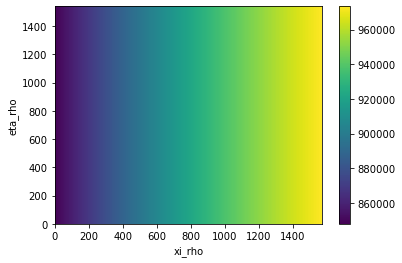

In [13]:
area = (gigatl01w.pm**-1 * gigatl01w.pn**-1)

area.plot()

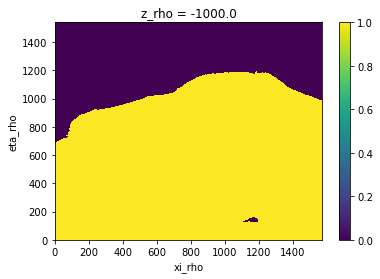

In [14]:
sw = grid.transform(gigatl01w.salt.where(gigatl01w.mask_rho==1).isel(time=0).chunk({'s_rho':-1}), 
                    'z', zs, 
                    target_data=gigatl01w.z_rho.isel(time=0))
mask = ~np.ma.masked_invalid(sw).mask

pad = 1
xrmask = xr.DataArray(mask.astype(np.float64), dims=sw.dims,
                      coords=sw.coords
                     )
mask[:2,:] = 0.
mask[-2:,:] = 0.
mask[:,:2] = 0.
mask[:,-2:] = 0.
wet_mask = xr.DataArray(mask.astype(np.float64), dims=sw.dims,
                        coords=sw.coords
                       )

wet_mask.isel(z_rho=-1).plot()

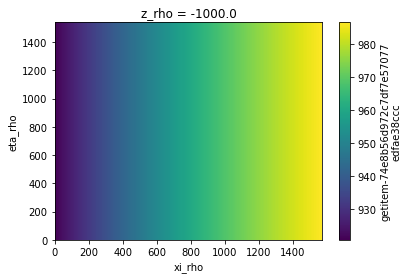

In [15]:
dxw = xr.DataArray(grid.interp(gigatl01w.pm**-1,
                               'x').isel(eta_rho=slice(None,-1)).data,  # x-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'], 
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  )
dxw[:,:] = np.nan_to_num(dxw[:,:],nan=1)

dyw = xr.DataArray(grid.interp(gigatl01w.pn**-1,
                               'x').isel(eta_rho=slice(None,-1)).data,  # y-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  )
dyw[:,:] = np.nan_to_num(dyw[:,:],nan=1)

dxs = xr.DataArray(grid.interp(gigatl01w.pm**-1,
                               'y').isel(xi_rho=slice(None,-1)).data,  # x-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  ) 
dxs[:,:] = np.nan_to_num(dxs[:,:],nan=1)

dys = xr.DataArray(grid.interp(gigatl01w.pn**-1,
                               'y').isel(xi_rho=slice(None,-1)).data,  # y-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  ) 
dys[:,:] = np.nan_to_num(dys[:,:],nan=1)
dxw.plot()

In [15]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values
dx_min

array(920.77026, dtype=float32)

In [16]:
kappa_w = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),z_rho=-1))

kappa_s = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),z_rho=-1)) 

In [17]:
filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=50,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.isel(eta_rho=slice(None,-1),
                                  xi_rho=slice(None,-1)).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxw': dxw.chunk({'eta_rho':-1,'xi_rho':-1}), 'dyw': dyw.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxs': dxs.chunk({'eta_rho':-1,'xi_rho':-1}), 'dys': dys.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'area': area.isel(eta_rho=slice(None,-1),
                          xi_rho=slice(None,-1)).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_w': kappa_w.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_s': kappa_s.chunk({'eta_rho':-1,'xi_rho':-1})
    }
)

In [19]:
bm = filter_30km.apply(bw.isel(eta_rho=slice(None,-1),
                               xi_rho=slice(None,-1)
                              ).chunk({'eta_rho':-1,'xi_rho':-1}), 
                       dims=['eta_rho', 'xi_rho']
                      ).chunk({'eta_rho':200,'xi_rho':200})
bm

<xarray.DataArray (time: 89, z_rho: 50, eta_rho: 1540, xi_rho: 1575)>
dask.array<rechunk-merge, shape=(89, 50, 1540, 1575), dtype=float64, chunksize=(1, 50, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * z_rho    (z_rho) float64 -1.0 -4.497 -7.994 -11.49 ... -897.8 -948.8 -1e+03
Dimensions without coordinates: eta_rho, xi_rho

In [16]:
At = (gigatl01w.pm**-1 * gigatl01w.pn**-1).isel(eta_rho=slice(1,-1),xi_rho=slice(1,-1))
Au = (dyw * dxw).isel(eta_rho=slice(1,-1),xi_rho=slice(1,-1))
Av = (dys * dxs).isel(eta_rho=slice(1,-1),xi_rho=slice(1,-1))


ncoars = 7

In [23]:
MLDw_coar = ((MLDw.isel(eta_rho=slice(1,-1),xi_rho=slice(1,-1))
              *At).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
MLDw_coar

<xarray.DataArray (time: 89, eta_rho: 219, xi_rho: 224)>
dask.array<mul, shape=(89, 219, 224), dtype=float64, chunksize=(10, 29, 29), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(28, 28), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(28, 28), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho

In [24]:
bmx = grids.interp(bm, 'x', boundary='fill')
bmy = grids.interp(bm, 'y', boundary='fill')
dbmx = grids.diff(bmx,'x',boundary='fill') * gigatl01w.pm.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))
dbmy = grids.diff(bmy,'y',boundary='fill') * gigatl01w.pn.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))
M2 = np.sqrt(dbmx**2 + dbmy**2)
print(M2)

<xarray.DataArray (time: 89, z_rho: 50, eta_rho: 1540, xi_rho: 1575)>
dask.array<sqrt, shape=(89, 50, 1540, 1575), dtype=float64, chunksize=(1, 50, 198, 198), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * z_rho    (z_rho) float64 -1.0 -4.497 -7.994 -11.49 ... -897.8 -948.8 -1e+03
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho


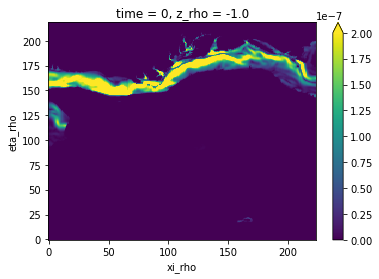

In [26]:
dbmx_coar = ((dbmx.isel(eta_rho=slice(1,None),xi_rho=slice(1,None))
              *At
             ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                       boundary='trim').sum(skipna=True)
             * At.coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                               boundary='trim').sum(skipna=True)**-1
            )
dbmy_coar = ((dbmy.isel(eta_rho=slice(1,None),xi_rho=slice(1,None))
              *At
             ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                       boundary='trim').sum(skipna=True)
             * At.coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                               boundary='trim').sum(skipna=True)**-1
            )
M2_coar = ((M2.where(M2.z_rho>=MLDw.isel(eta_rho=slice(1,None),xi_rho=slice(1,None))
                    ).isel(eta_rho=slice(1,None),xi_rho=slice(1,None))
            * At
           ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                     boundary='trim').sum(skipna=True)
           * At.coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                              boundary='trim').sum(skipna=True)**-1
          )
M2_coar.isel(time=0,z_rho=0).plot(vmax=2e-7)

In [28]:
xrdzp1s = xr.DataArray(dzp1s, dims='z_rho', coords={'z_rho':bm.z_rho})

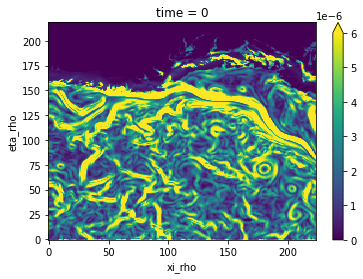

In [35]:
dbmy_coarH = (dbmy_coar
              * xrdzp1s.where(xrdzp1s.z_rho>=MLDw).isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)
                                                       ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('z_rho', skipna=True)
dbmx_coarH = (dbmx_coar
              * xrdzp1s.where(xrdzp1s.z_rho>=MLDw).isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)
                                                       ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('z_rho', skipna=True)
M2_coarH = (M2_coar 
            * xrdzp1s.where(xrdzp1s.z_rho>=MLDw).isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)
                                                     ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                    boundary='trim').mean(skipna=True)
           ).sum('z_rho', skipna=True)
M2_coarH.isel(time=0).plot(vmax=6e-6)

In [17]:
import gsw
f = gsw.f(gigatl01w.lat_rho.where(gigatl01w.mask_rho!=0.).isel(eta_rho=slice(pad+1,-2-pad),
                                                               xi_rho=slice(pad+1,-2-pad)
                                                              ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                         boundary='trim').mean(skipna=True)
         )

f

<xarray.DataArray 'lat_rho' (eta_rho: 219, xi_rho: 224)>
dask.array<mul, shape=(219, 224), dtype=float32, chunksize=(29, 29), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(28, 28), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(28, 28), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho

In [38]:
MLI = xr.zeros_like(M2_coarH).load()

for i in range(len(MLI.time)):
    MLI[i] = (M2_coarH.isel(time=i)**2 
              / f).where(xrmask.sel(z_rho=-1e2, method='nearest'
                                   ).isel(eta_rho=slice(pad+1,-2-pad),
                                          xi_rho=slice(pad+1,-2-pad)
                                         ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                   boundary='trim').mean(skipna=True)!=0.
                        ).reset_coords(drop=True).chunk({'eta_rho':80,'xi_rho':80}
                                                       )
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [ ]:
tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'MLI-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)

MLI.to_dataset(name='MLI').to_zarr(store_tmp, mode='w')

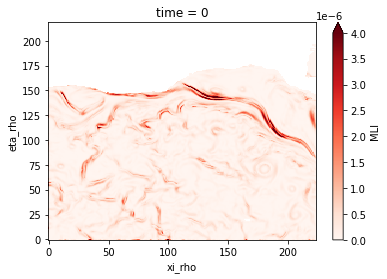

In [18]:
MLI = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLI-30km_z0-MLD_fma.zarr")
                  ).MLI
MLI.isel(time=0).plot(cmap='Reds', vmin=0, vmax=4e-6)

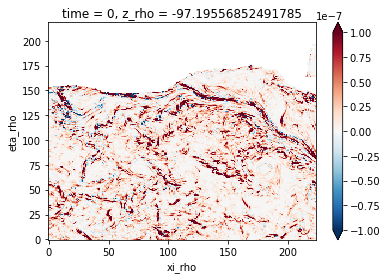

In [19]:
wpbp = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/wb-30km_z0-MLD_fma.zarr")
                   ).wpbp
wpbp_coar = ((wpbp * At.isel(eta_rho=slice(2,-1),xi_rho=slice(2,-1))).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                                  boundary='trim').sum(skipna=True)
             * At.isel(eta_rho=slice(2,-1),xi_rho=slice(2,-1)).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            ).where(xrmask.sel(z_rho=-1e2, method='nearest'
                              ).isel(eta_rho=slice(2,-1),xi_rho=slice(2,-1)
                                    ).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                              boundary='trim').mean(skipna=True)!=0.
                   )
wpbp_coar.isel(time=0).plot(cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

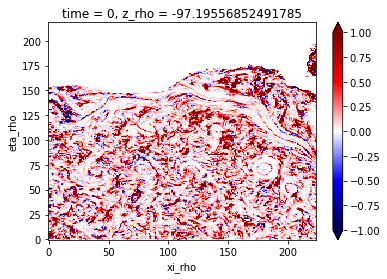

In [26]:
(wpbp_coar / MLI).isel(time=0).plot(vmax=1, cmap='seismic')

In [20]:
alpha = (wpbp_coar / MLI).median(['eta_rho','xi_rho'],skipna=True).compute()

aMLI = alpha*MLI
aMLI.name = 'MLI'
wpbp_coar.name = 'wpbp'

In [21]:
time = np.arange('2010-02', '2010-05', dtype='datetime64[D]')
time

array(['2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04',
       '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08',
       '2010-02-09', '2010-02-10', '2010-02-11', '2010-02-12',
       '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16',
       '2010-02-17', '2010-02-18', '2010-02-19', '2010-02-20',
       '2010-02-21', '2010-02-22', '2010-02-23', '2010-02-24',
       '2010-02-25', '2010-02-26', '2010-02-27', '2010-02-28',
       '2010-03-01', '2010-03-02', '2010-03-03', '2010-03-04',
       '2010-03-05', '2010-03-06', '2010-03-07', '2010-03-08',
       '2010-03-09', '2010-03-10', '2010-03-11', '2010-03-12',
       '2010-03-13', '2010-03-14', '2010-03-15', '2010-03-16',
       '2010-03-17', '2010-03-18', '2010-03-19', '2010-03-20',
       '2010-03-21', '2010-03-22', '2010-03-23', '2010-03-24',
       '2010-03-25', '2010-03-26', '2010-03-27', '2010-03-28',
       '2010-03-29', '2010-03-30', '2010-03-31', '2010-04-01',
       '2010-04-02', '2010-04-03', '2010-04-04', '2010-

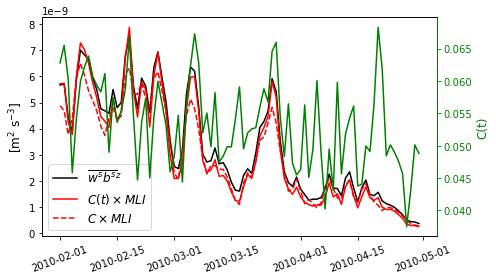

In [22]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['eta_rho','xi_rho'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, aMLI.median(['eta_rho','xi_rho'],skipna=True), c='r', label=r'$C(t) \times MLI$')
ax.plot(time, (alpha.mean('time')*MLI).median(['eta_rho','xi_rho'],skipna=True), c='r', ls='--', label=r'$C \times MLI$')

ax2.plot(time, alpha, c='g')

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2010-02-01','2010-02-15','2010-03-01','2010-03-15','2010-04-01','2010-04-15','2010-05-01'])
ax.set_xticklabels(labels=['2010-02-01','2010-02-15','2010-03-01','2010-03-15','2010-04-01','2010-04-15','2010-05-01'],
                   rotation=20)
ax2.set_ylabel(r"C(t)", fontsize=12, c='g')
ax2.spines['right'].set_color('g')
ax2.tick_params(axis='y', colors='g')

ax.legend(loc='lower left', fontsize=12)
plt.savefig('/home/jovyan/Figures/GIGATL-wb-timeseries_01.pdf')

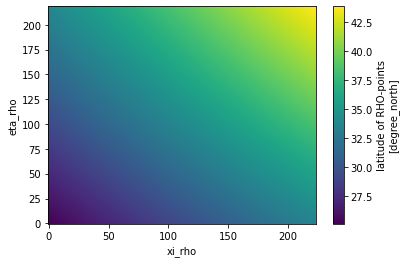

In [24]:
lat_coar = gigatl01w.lat_rho.isel(eta_rho=slice(1,-1),xi_rho=slice(1,-1)).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
lon_coar = gigatl01w.lon_rho.isel(eta_rho=slice(1,-1),xi_rho=slice(1,-1)).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
lat_coar.plot()

In [25]:
mask = gigatl01w.mask_rho.isel(eta_rho=slice(2,-1),xi_rho=slice(2,-1)).coarsen({'eta_rho':ncoars,'xi_rho':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
mask = ~np.ma.masked_values(mask,0).mask
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

/tmp/ipykernel_3418/832618948.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(lon_coar, lat_coar, wpbp_coar.isel(time=0),
/tmp/ipykernel_3418/832618948.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(lon_coar, lat_coar, aMLI.isel(time=0),
/tmp/ipykernel_3418/832618948.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the cor

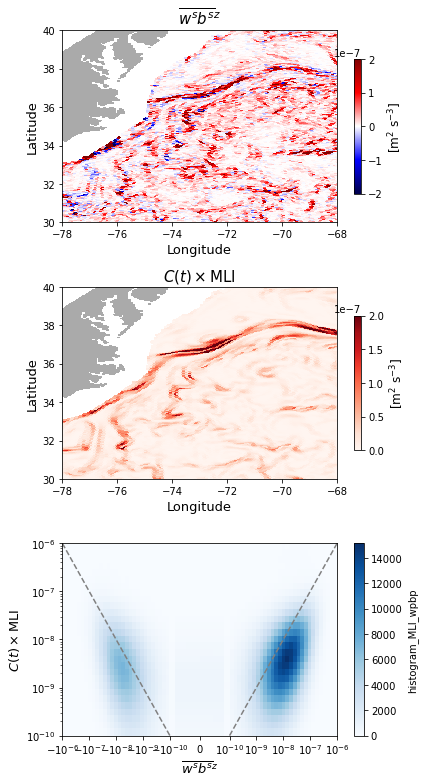

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,11),nrows=3,ncols=1)
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(lon_coar, lat_coar, wpbp_coar.isel(time=0),
                   vmin=-2e-7, vmax=2e-7, cmap='seismic', rasterized=True)
im2 = ax2.pcolormesh(lon_coar, lat_coar, aMLI.isel(time=0),
                   vmin=0., vmax=2e-7, cmap='Reds', rasterized=True)

ax1.pcolormesh(lon_coar, lat_coar, 
               np.ma.masked_array(mask, mask),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(lon_coar, lat_coar, 
               np.ma.masked_array(mask, mask),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

xhist((aMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])

ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthresh=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax3.set_ylabel(r"$C(t)\times$MLI", fontsize=13)
ax1.set_title(r"$\overline{w^sb^s}^z$", fontsize=15)
ax1.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)
ax2.set_title(r"$C(t)\times$MLI", fontsize=15)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax2.set_ylabel(r"Latitude", fontsize=13)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/GIGATL-wb-hist_01.pdf')